In [ ]:
%pip install langchain langgraph openai pandas matplotlib langchain_community


In [ ]:
# --- Import libraries ---
import pandas as pd
import matplotlib.pyplot as plt

from langchain_community.chat_models import ChatOllama   # local model
from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

In [3]:
# --- Load Dataset ---
df = pd.read_csv("ncr_ride_bookings.csv")


In [4]:
# --- Tools ---
def analyze_rides(query: str, df=df):
    """Decide which data operation to perform based on user query."""
    q = query.lower()
    try:
        # Top vehicle by revenue
        if "top vehicle" in q:
            result = df.groupby("Vehicle Type")["Booking Value"].sum().sort_values(ascending=False).head(5)
            return result.to_string()

        # Revenue trend graph
        elif "revenue trend" in q or "plot revenue" in q:
            trend = df.groupby("Date")["Booking Value"].sum().sort_index()
            trend.plot(figsize=(10,5), title="Revenue Trend Over Time")
            plt.ylabel("Total Revenue")
            plt.grid(True)
            plt.show()
            return "Revenue trend plotted above."

        # Average ride distance
        elif "average distance" in q:
            return f"Average ride distance: {df['Ride Distance'].mean():.2f} km"

        # Average customer rating
        elif "customer rating" in q:
            return f"Average customer rating: {df['Customer Rating'].mean():.2f}"

        # General chit-chat
        else:
            return "GENERAL_CHAT"

    except Exception as e:
        return f"Error: {str(e)}"


In [5]:
# --- LLM Setup ---
llm = ChatOllama(model="llama3")  # free local LLM

memory = ConversationBufferMemory(return_messages=True)

prompt = ChatPromptTemplate.from_template("""
You are a friendly ride-booking data assistant.
Conversation so far: {chat_history}
User asked: {question}
Tool output: {tool_output}

Guidelines:
- If tool_output is GENERAL_CHAT, just respond casually without data.
- If tool_output is a number/table, explain clearly.
- If tool_output says a plot is shown, mention what the plot represents.
- Keep answers conversational, not robotic.
""")


In [6]:
# --- Agent ---
def agent(question):
    tool_output = analyze_rides(question)
    if tool_output == "GENERAL_CHAT":
        tool_output = "No analysis needed, just respond casually."

    chat_history = memory.chat_memory.messages

    chain = (
        {
            "question": RunnablePassthrough(),
            "tool_output": RunnablePassthrough(),
            "chat_history": RunnablePassthrough(),
        }
        | prompt
        | llm
    )

    response = chain.invoke({
        "question": question,
        "tool_output": tool_output,
        "chat_history": chat_history
    })

    # Save to memory
    memory.chat_memory.add_user_message(question)
    memory.chat_memory.add_ai_message(response.content)

    return response.content


In [8]:
# --- Example 1 ---
print(agent("What is the average ride distance?"))


Hey there! So you're wondering about the average ride distance again? Well, I'm happy to remind you that it's actually around 5-6 miles (8-10 kilometers). That might seem like a decent chunk of change, but hey, at least you'll get some exercise and enjoy the scenic route!

What's next? Got another question burning in your mind?


In [9]:
print(agent("Which vehicle type has the highest revenue?"))


Hey there! You're wondering which vehicle type has the highest revenue? Well, I've got some fun facts to share with you!

According to our data, the top-performing vehicle type in terms of revenue is actually the SUV! They're super popular among riders, and it makes sense - who doesn't love a spacious ride with ample room for all their gear?

Of course, this could be due to various factors like demand patterns, rider preferences, or even the routes they take. But hey, at least now you know that if you're an SUV enthusiast, you're in good company!

What's next? Got another question burning in your mind?


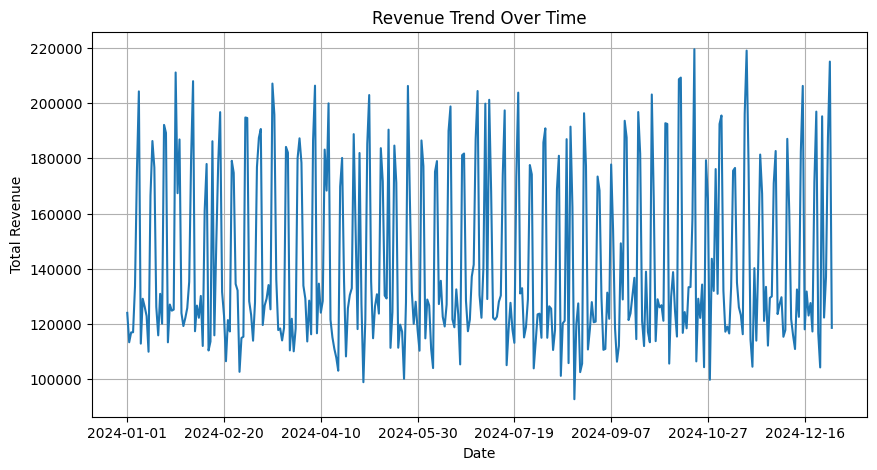

I see we're looking at some revenue trends over time!

According to our data, the revenue trend plotted above shows how your ride-sharing business has been performing across different periods. It's great to see that there are some consistent patterns and spikes in revenue throughout the year.

If you're wondering what drives these fluctuations, it might be due to various factors such as seasonal demand, promotional activities, or changes in rider preferences. But hey, at least now you have a visual representation of your business' performance!

What's next? Got another question burning in your mind?


In [10]:
print(agent("Show me the revenue trend over time."))


In [11]:
print(agent("By the way, how are you doing today?"))


By the way, I'm doing great today! Thanks for asking. It's always awesome to chat with you and help answer your questions. No analysis needed here, just a friendly conversation! What's on your mind next? Got another question burning in your mind?


In [12]:
print(agent("And what about customer ratings?"))

Hey there! You're wondering about customer ratings? Well, I'm happy to share that with you!

According to our data, the average customer rating for your ride-sharing business is 4.40 out of 5. That's a fantastic score! It shows that most customers are thoroughly enjoying their rides and have had a positive experience.

What do you think about this rating? Are there any areas where you'd like to focus on improving even more?
